In [29]:
!pip install torch scikit-learn pandas numpy matplotlib tqdm joblib

In [30]:
from google.colab import files
uploaded = files.upload()

Saving labeled_news.csv to labeled_news (2).csv


In [31]:
import pandas as pd

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

df.head()

,keyword,title,description,link,pubDate,label
0,IT,Entertainment industry comes together to honor...,“<b>It</b> is heartbreaking to think there is ...,https://m.entertain.naver.com/article/640/0000...,"Wed, 26 Nov 2025 19:10:00 +0900",0
1,IT,법무법인 선운-日 가와하라 법률사무소 '맞손'…&quot;효율적 법률 서비스 제...,"최근 한일 양국 기업 간 교류는 수출, 투자, 프랜차이즈, <b>IT</b>, 제조...",https://n.news.naver.com/mnews/article/215/000...,"Wed, 26 Nov 2025 19:09:00 +0900",1
2,IT,"데이터얼라이언스·FPT, 베트남 GPU 활용한 AI 인프라 동맹 결성","인공지능(AI)과 클라우드 기술에서 협업 기반을 넓히기 위한 움직임으로, 국내 클라...",https://www.tokenpost.kr/news/ai/308317,"Wed, 26 Nov 2025 19:06:00 +0900",1
3,IT,"안전보건공단, 공작기계산업협회와 산재 예방 동행",최근에는 <b>IT</b>기술과 네트워킹을 활용한 융·복합 공작기계로 빠르게 변화되...,https://www.energy-news.co.kr/news/articleView...,"Wed, 26 Nov 2025 19:06:00 +0900",1
4,IT,What the Pentagon’s Attack Videos Reveal About...,attacks on vessels <b>it</b> says are traffick...,https://www.nytimes.com/2025/11/26/us/what-the...,"Wed, 26 Nov 2025 19:06:00 +0900",1


In [32]:
df["text"] = df["title"].astype(str) + " " + df["description"].astype(str)
df = df[["text", "label"]]

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    df["text"], df["label"], test_size=0.3, stratify=df["label"], random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

test_df = pd.DataFrame({
    "text": X_test,
    "label": y_test
})

test_df.to_csv("test.csv", index=False)
print("✅ test.csv 저장 완료")


✅ test.csv 저장 완료


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')

X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_val_vec   = vectorizer.transform(X_val).toarray()
X_test_vec  = vectorizer.transform(X_test).toarray()

In [35]:
import torch

X_train_t = torch.tensor(X_train_vec, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)

X_val_t   = torch.tensor(X_val_vec, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values, dtype=torch.long)

X_test_t  = torch.tensor(X_test_vec, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

In [36]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)

In [37]:
import torch.nn as nn

class NewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = NewsClassifier(X_train_t.shape[1])

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
from tqdm import tqdm

def train_epoch(model, loader):
    model.train()
    total_loss, correct = 0, 0

    for X, y in loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(1)
        correct += (pred == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc

In [40]:
def eval_epoch(model, loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in loader:
            output = model(X)
            loss = criterion(output, y)
            total_loss += loss.item()
            pred = output.argmax(1)
            correct += (pred == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc

In [41]:
epochs = 10

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f" Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/10
 Train Loss: 0.6496, Acc: 0.7048
 Val   Loss: 0.5417, Acc: 0.8481
Epoch 2/10
 Train Loss: 0.3770, Acc: 0.9278
 Val   Loss: 0.3222, Acc: 0.8963
Epoch 3/10
 Train Loss: 0.1504, Acc: 0.9762
 Val   Loss: 0.2670, Acc: 0.9037
Epoch 4/10
 Train Loss: 0.0692, Acc: 0.9873
 Val   Loss: 0.2585, Acc: 0.8889
Epoch 5/10
 Train Loss: 0.0349, Acc: 0.9952
 Val   Loss: 0.2630, Acc: 0.8889
Epoch 6/10
 Train Loss: 0.0230, Acc: 0.9960
 Val   Loss: 0.2674, Acc: 0.8926
Epoch 7/10
 Train Loss: 0.0172, Acc: 0.9984
 Val   Loss: 0.2726, Acc: 0.8852
Epoch 8/10
 Train Loss: 0.0114, Acc: 0.9992
 Val   Loss: 0.2819, Acc: 0.9000
Epoch 9/10
 Train Loss: 0.0088, Acc: 0.9984
 Val   Loss: 0.2828, Acc: 0.8926
Epoch 10/10
 Train Loss: 0.0071, Acc: 0.9992
 Val   Loss: 0.2899, Acc: 0.8926


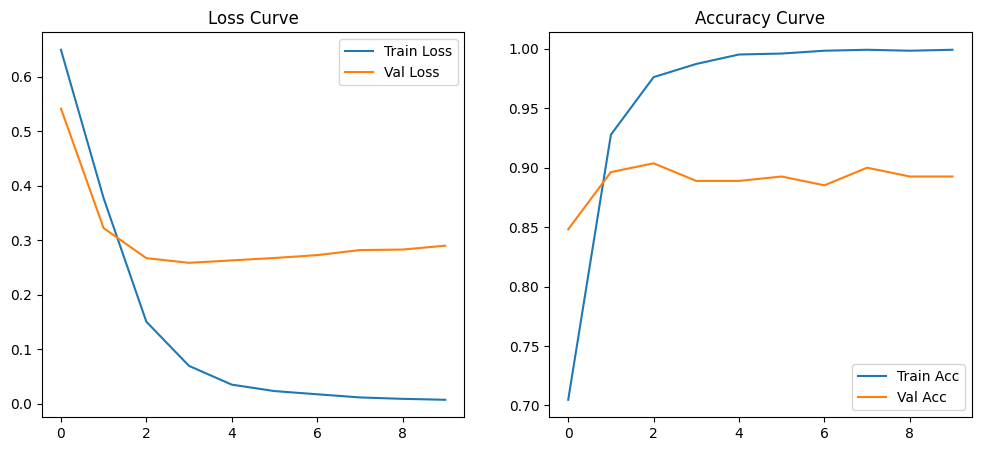

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [ ]:
torch.save(model.state_dict(), "news_model.pth")

import joblib
joblib.dump(vectorizer, "tfidf.pkl")

['tfidf.pkl']

In [44]:
from google.colab import files
files.download("news_model.pth")
files.download("tfidf.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>